In [ ]:
import pandas as pd

import numpy as np
from numpy import linalg as LA
from numpy.linalg import *

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Linear Regression

In [ ]:
'''
    Linear Regression via Gradient Descent
'''

class LinearRegression:

    def __init__(self, init_theta=None, alpha=0.01, n_iter=100):
        '''
        Constructor
        '''
        self.alpha = alpha
        self.n_iter = n_iter
        self.theta = init_theta
        self.JHist = None
    

    def gradientDescent(self, X, y, theta):
        '''
        Fits the model via gradient descent
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-dimensional numpy vector
            theta is a d-dimensional numpy vector
        Returns:
            the final theta found by gradient descent
        '''
        n,d = X.shape
        self.JHist = []
        for i in range(self.n_iter):
            self.JHist.append( (self.computeCost(X, y, theta), theta) )
            print("Iteration: ", i+1, " Cost: ", self.JHist[i][0], " Theta.T: ", theta.T)
            yhat = X*theta
            theta = theta -  (X.T * (yhat - y)) * (self.alpha / n)
        return theta
    

    def computeCost(self, X, y, theta):
        '''
        Computes the objective function
        Arguments:
          X is a n-by-d numpy matrix
          y is an n-dimensional numpy vector
          theta is a d-dimensional numpy vector
        Returns:
          a scalar value of the cost  
              ** Not returning a matrix with just one value! **
        '''
        n,d = X.shape
        yhat = X*theta
        J =  (yhat-y).T * (yhat-y) / n
        J_scalar = J.tolist()[0][0]  # convert matrix to scalar
        return J_scalar
    

    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas Dataframe
            y is an n-dimensional Pandas Series
        '''
        n = len(y)
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term

        y = y.to_numpy()
        n,d = X.shape
        y = y.reshape(n,1)

        if self.theta is None:
            self.theta = np.matrix(np.zeros((d,1)))

        self.theta = self.gradientDescent(X,y,self.theta)   


    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas DataFrame
        Returns:
            an n-dimensional numpy vector of the predictions
        '''
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term
        return pd.DataFrame(X*self.theta)

### Test code for linear regression

In [ ]:
def test_linreg(n_iter = 2000):
  # load the data
  filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw2-multivariateData.csv"
  df = pd.read_csv(filepath, header=None)

  X = df[df.columns[:-1]]
  y = df[df.columns[-1]]

  n,d = X.shape

  # # Standardize features
  from sklearn.preprocessing import StandardScaler
  standardizer = StandardScaler()
  X = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization

  # # initialize the model
  init_theta = np.matrix(np.random.randn((d+1))).T
  alpha = 0.01

  # # Train the model
  lr_model = LinearRegression(init_theta = init_theta, alpha = alpha, n_iter = n_iter)
  lr_model.fit(X,y)

  # # Compute the closed form solution
  X = np.asmatrix(X.to_numpy())
  X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term
  y = np.asmatrix(y.to_numpy())
  n,d = X.shape
  y = y.reshape(n,1)
  thetaClosedForm = inv(X.T*X)*X.T*y
  print("thetaClosedForm: ", thetaClosedForm.T)

# Run the Linear Regression Test

In [ ]:
# test_linreg(2000)

Iteration:  1  Cost:  131184748023.2505  Theta.T:  [[-2.10557616 -0.98270053 -0.09510641]]
Iteration:  2  Cost:  128597170034.16953  Theta.T:  [[3402.04207534 1056.66899397  546.99956502]]
Iteration:  3  Cost:  126063620599.49669  Theta.T:  [[6772.14825033 2100.68062078 1082.7007871 ]]
Iteration:  4  Cost:  123582939641.51616  Theta.T:  [[10108.55336358  3131.25238017  1607.19887425]]
Iteration:  5  Cost:  121153992852.8283  Theta.T:  [[13411.59442568  4148.5814047   2120.68111665]]
Iteration:  6  Cost:  118775671099.91618  Theta.T:  [[16681.60507717  5152.86180682  2623.33182773]]
Iteration:  7  Cost:  116446889841.17358  Theta.T:  [[19918.91562215  6144.28472578  3115.33239081]]
Iteration:  8  Cost:  114166588559.0261  Theta.T:  [[23123.85306167  7123.03837375  3596.86130505]]
Iteration:  9  Cost:  111933730205.78769  Theta.T:  [[26296.7411268   8089.30808125  4068.09423071]]
Iteration:  10  Cost:  109747300662.90321  Theta.T:  [[29437.90031127  9043.27634183  4529.20403365]]
Iterati

# Polynomial Regression

In [ ]:
'''
    Template for polynomial regression
'''

import numpy as np

from sklearn.model_selection import KFold
from scipy.stats import mode

#-----------------------------------------------------------------
#  Class PolynomialRegression
#-----------------------------------------------------------------

class PolynomialRegression:

    def __init__(self, degree = 1, regLambda = 0.01, tuneLambda = False, regLambdaValues = np.zeros(10)):
        '''
        Constructor
        '''
        
        self.degree = degree
        self.reglambda = regLambda
        self.theta = np.matrix(np.zeros((degree+1))).T
        self.JHist = None
        self.conv = False
        self.alpha = 0.1
        self.thre = 1e-4
        self.train = pd.DataFrame(columns = range(degree))
        
        self.tune = tuneLambda
        self.lambdavalues = regLambdaValues


    def polyfeatures(self, X, degree):
        '''
        Expands the given X into an n * d array of polynomial features of
            degree d.

        Returns:
            A n-by-d data frame, with each column comprising of
            X, X * X, X ** 3, ... up to the dth power of X.
            Note that the returned matrix will not include the zero-th power.

        Arguments:
            X is an n-by-1 data frame
            degree is a positive integer
        '''
         
        newX = pd.DataFrame(columns = range(degree))

        for i in range(degree):
            newX.iloc[:,i] = X.iloc[:,0].values**(i+1)
        
        return newX
    
    
    def gradientDescent(self, X, y, theta):
        '''
        Fits the model via gradient descent
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-dimensional numpy vector
            theta is a d-dimensional numpy vector
        Returns:
            the final theta found by gradient descent
        '''

        self.conv = False
        n,d = X.shape
        self.JHist = []
        i = 0
        print(self.reglambda)
        while self.conv == False: 
            self.JHist.append( (self.computeCost(X, y, theta), theta) )
            # print("Iteration: ", i+1, " Cost: ", self.JHist[i][0], " Theta.T: ", theta.T)
            # print(self.JHist[i][0])
            yhat = X * theta
            lasttheta = theta
            theta = theta - (X.T * (yhat - y)) * (self.alpha / n) - self.alpha * self.reglambda * theta
            theta[0] = lasttheta[0] - sum((yhat - y) * (self.alpha / n))
            if np.linalg.norm(theta-lasttheta) < self.thre:
                self.conv = True
            if (self.JHist[i][0] > 100000):
                break
            i = i+1
        
        # print(i)
        
        return theta 
            
            
    def computeCost(self, X, y, theta):
        '''
        Computes the objective function
        Arguments:
          X is a n-by-d numpy matrix
          y is an n-dimensional numpy vector
          theta is a d-dimensional numpy vector
        Returns:
          a scalar value of the cost  
              ** Not returning a matrix with just one value! **
        '''
        
        n,d = X.shape
        yhat = X*theta
        J =  (yhat-y).T * (yhat-y) / n + self.reglambda * (np.linalg.norm(theta[1:self.degree-1])**2)
        J_scalar = J.tolist()[0][0]  # convert matrix to scalar
        
        return J_scalar
    
    
    def fit(self, X, y):
        '''
            Trains the model
            Arguments:
                X is a n-by-1 data frame
                y is an n-by-1 data frame
            Returns:
                No return value
            Note:
                You need to apply polynomial expansion and scaling first
        '''
        
        X = self.polyfeatures(X, self.degree)
        
        for i in X.columns:
            self.train.iloc[:,i] = X.iloc[:,i].values
            X[i] = (X[i]-X[i].mean())/X[i].std()
            
        n = len(y)
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term
        
        y = y.to_numpy()
        n,d = X.shape
        y = y.reshape(n,1)
        
        scorelist = []
        best_lambda = self.reglambda
        
        if self.tune == False:
            self.theta = self.gradientDescent(X,y,self.theta)
        else:
            self.alpha = 0.01
            kf = KFold(n_splits=3)
            lamarr = []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                costvalues = []
                for L in self.lambdavalues:
                    self.reglambda = L
                    self.theta = self.gradientDescent(X_train,y_train,self.theta)
                    y_predict = X_test*self.theta
                    cost = (y_predict-y_test).T * (y_predict-y_test)/n
                    costvalues.append(cost)
                    self.theta = np.matrix(np.zeros((self.degree+1))).T
                
                print(costvalues)
                ind = costvalues.index(min(costvalues))
                print(ind)
                lamarr.append(ind)
            print(lamarr)
            self.reglambda = self.lambdavalues[mode(lamarr).mode[0]]
            # clf = RidgeCV(alphas=self.lambdavalues,cv=2).fit(X, y)
            # self.reglambda = clf.alpha_
            print(self.reglambda)
            self.theta = self.gradientDescent(X,y,self.theta)
                       
        return self.reglambda
            
        
    def predict(self, X):
        '''
        Use the trained model to predict values for each instance in X
        Arguments:
            X is a n-by-1 data frame
        Returns:
            an n-by-1 data frame of the predictions
        '''
        
        X = self.polyfeatures(X, self.degree)
        
        for i in X.columns:
            X[i] = (X[i]-self.train[i].mean())/self.train[i].std()
          
        n,d = X.shape
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term
        
        return pd.DataFrame(X*self.theta)

# Test Polynomial Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def test_polyreg_univariate():
    '''
        Test polynomial regression
    '''

    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw2-polydata.csv"
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    
    # regression with degree = d
    d = 8
    Lambdas = np.array([0.001,0.003,0.006,0.01,0.03,0.006,0.1,0.3,0.6,1])
    model = PolynomialRegression(degree = d, regLambda = 0.01, tuneLambda = True, regLambdaValues = Lambdas)
    model.fit(X, y)
    
    # output predictions
    xpoints = pd.DataFrame(np.linspace(np.max(X), np.min(X), 100))
    ypoints = model.predict(xpoints)

    # plot curve
    plt.figure()
    plt.plot(X, y, 'rx')
    plt.title('PolyRegression with d = '+str(d))
    plt.plot(xpoints, ypoints, 'b-')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
     

In [ ]:
    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw2-polydata.csv"
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    
    Lambdas = np.array([0.001,0.003,0.006,0.01,0.03,0.06,0.1,0.3,0.6,1])
    model = PolynomialRegression(degree = 8, regLambda = 0.01, tuneLambda = True, regLambdaValues = Lambdas)
    result = model.fit(X, y)
    

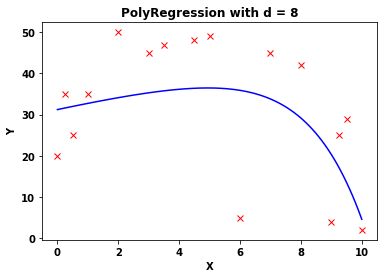

In [ ]:
'''
xpoints = pd.DataFrame(np.linspace(np.max(X), np.min(X), 100))
ypoints = model.predict(xpoints)

plt.figure()
plt.plot(X, y, 'rx')
plt.title('PolyRegression with d = '+str(8))
plt.plot(xpoints, ypoints, 'b-')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
'''
